<a href="https://colab.research.google.com/github/andypeng93/Flatiron_Image_Classification/blob/master/Flatiron_School_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please fill out:

*   Student name: Andy Peng
*   Student pace: Part Time
*   Scheduled project review date/time:
*   Instructor name: Victor Geislinger
*   Blog post URL: https://medium.com/@andypeng93/preprocessing-images-with-data-split-77250bbfbc99


I am tasked to create a model that can accurately predict whether the patient has Pneumonia or not given a patient's chest xray image. Our dataset comes from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The dataset contains three folders training, validation and testing. Each folder is filled with chest xray images used for training and testing the model that we will create.

# List of imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
from keras import models, layers, optimizers, regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score

np.random.seed(123)

# Preprocessing Images

Our data distribution for the three folders is as follows


*   Training Data - 5,216 Images
*   Validation Data - 16 Images
*   Testing Data - 624 Images

Due to the low amount of validation data, we will be combining the training and validation data and apply train test split on it to create a new validation dataset. The following code will first create the list filenames which contains all the directories to all the images in our training and validation dataset. Then by using train test split function we would split up the list with 90% for training and 10% for validation.



In [ ]:
filenames = tf.io.gfile.glob('/content/drive/My Drive/Flatiron School/chest_xray/train/*/*')
filenames.extend(tf.io.gfile.glob('/content/drive/My Drive/Flatiron School/chest_xray/val/*/*'))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


In [ ]:
COUNT_NORMALV = len([filename for filename in val_filenames if "NORMAL" in filename])
print("Normal images count in validation set: " + str(COUNT_NORMALV))

COUNT_PNEUMONIAV = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in validation set: " + str(COUNT_PNEUMONIAV))

Normal images count in validation set: 255
Pneumonia images count in validation set: 792


The count of Pneumonia x-ray images is three times the count of Normal x-ray images. Due to the imbalance in our data, we would need to fix this issue later on when modeling. But before we move onto modeling we would need to create the correct x and y values to pass through ImageDataGenerator.flow(). 

In [ ]:
#Function below runs through each directory, load the image and convert it to an array.
def image_arr(file):
    image = tf.keras.preprocessing.image.load_img(file, target_size = (150, 150))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr
#Applying the map function along with the function above to create a map object
x_train = map(image_arr, train_filenames)
#Convert the map object to list and then numpy array aka tensor.
x_train = np.array(list(x_train))
x_val = map(image_arr, val_filenames)
x_val = np.array(list(x_val))

In [ ]:
#Function below runs through each directory and returns 1 for PNEUMONIA or 0 for NORMAL
def label(file):
  if 'PNEUMONIA' in file:
    return 1
  else:
    return 0
y_train = map(label, train_filenames)
y_train = np.array(list(y_train))
y_val = map(label, val_filenames)
y_val = np.array(list(y_val))

In [ ]:
x_train.shape

(4185, 150, 150, 3)

After preprocessing the data we can then run the values through an ImageDataGenerator to start training our model. 

# Modeling

We will start things off with a baseline model for comparison. As a baseline model we will use the most basic convolutional neural networks.

## Convolutional Nerual Networks - ModelB (Baseline Model)

In [ ]:
train_datagenB = ImageDataGenerator(1./225)
test_datagenB = ImageDataGenerator(1./225)
train_generatorB = train_datagenB.flow(x = x_train, y = y_train, batch_size = 16, seed = 123)
val_generatorB = test_datagenB.flow(x = x_val, y = y_val, batch_size = 16, seed = 123)
test_generatorB = test_datagenB.flow_from_directory(
        '/content/drive/My Drive/Flatiron School/chest_xray/test',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        seed = 123)

Found 624 images belonging to 2 classes.


In [ ]:
#Add a callback so that we can save time to stop running if our validation loss does not decrease anymore.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
modelB = models.Sequential()
modelB.add(layers.Conv2D(32, (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
modelB.add(layers.MaxPooling2D((2, 2)))
modelB.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
modelB.add(layers.MaxPooling2D((2, 2)))
modelB.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
modelB.add(layers.MaxPooling2D((2, 2)))
modelB.add(layers.Flatten())
modelB.add(layers.Dense(128, activation = 'relu'))
modelB.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
nadam = optimizers.Nadam(learning_rate = 1e-4)
modelB.compile(loss = 'binary_crossentropy',
               optimizer = 'nadam',
               metrics = ['acc'])

In [ ]:
historyB = modelB.fit_generator(train_generatorB,
                     steps_per_epoch = 261,
                     epochs = 30,
                     validation_data = val_generatorB,
                     validation_steps = 65,
                     verbose = 0,
                     callbacks = [callback])

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
test_lossB, test_accB = modelB.evaluate_generator(test_generatorB, steps=39)
print('test acc:', test_accB)

Instructions for updating:
Please use Model.evaluate, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


test acc: 0.7243589758872986


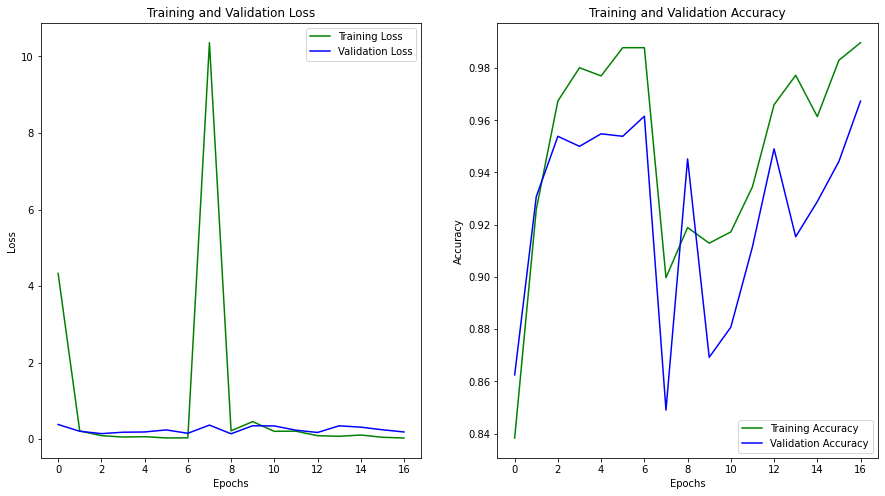

In [ ]:
#Define a function to graph our data to check for overfitting
def model_graph(data):
  loss_train = data.history['loss']
  loss_val = data.history['val_loss']
  acc_train = data.history['acc']
  acc_val = data.history['val_acc']
  
  epochs = data.epoch

  fig = plt.figure(figsize = (15, 8))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_train, 'g', label = 'Training Loss')
  plt.plot(epochs, loss_val, 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
  plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

model_graph(historyB)

Although the testing accuracy for the Convolutional Neural Networks Baseline Model is 72.3%, the model is not that great. If you look at the loss graph at epoch 7, the loss function had a huge jump. Also our training model is performing better than the validation model ignoring the jump at epoch 7. This hints at the model being overfitted. Therefore we would be adding in the following to our model to reduce overfitting.

* Data Augmentation
* Regularization - Dropouts
* Lower the learning rate (LR)

## Convolutional Neural Networks - ModelD (Data Augmentation/ Regularization/ Lower LR)

In [ ]:
train_datagenD = ImageDataGenerator(rotation_range = 0.2,
                                   shear_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   fill_mode = 'nearest',
                                   rescale = 1./255)
test_datagenD = ImageDataGenerator(rescale = 1./255)
train_generatorD = train_datagenD.flow(x = x_train, y = y_train, batch_size = 16, seed = 123)
val_generatorD = test_datagenD.flow(x = x_val, y = y_val, batch_size = 16, seed = 123)
test_generatorD = test_datagenD.flow_from_directory(
        '/content/drive/My Drive/Flatiron School/chest_xray/test',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 624 images belonging to 2 classes.


In [ ]:
modelD = models.Sequential()
modelD.add(layers.Conv2D(32, (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
modelD.add(layers.MaxPooling2D((2, 2)))
modelD.add(layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.005)))
modelD.add(layers.MaxPooling2D((2, 2)))
modelD.add(layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.005)))
modelD.add(layers.MaxPooling2D((2, 2)))
modelD.add(layers.Flatten())
modelD.add(layers.Dropout(0.4))
modelD.add(layers.Dense(128, activation = 'relu'))
modelD.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
nadam = optimizers.Nadam(learning_rate = 1e-5)
modelD.compile(loss = 'binary_crossentropy',
               optimizer = 'nadam',
               metrics = ['acc'])

In [ ]:
historyD = modelD.fit(train_generatorD,
                      steps_per_epoch = 261,
                      epochs = 50,
                      validation_data = val_generatorD,
                      validation_steps = 65,
                      verbose = 0,
                      callbacks = [callback])

In [ ]:
test_lossD, test_accD = modelD.evaluate_generator(test_generatorD, steps=39)
print('test acc:', test_accD)

test acc: 0.8637820482254028


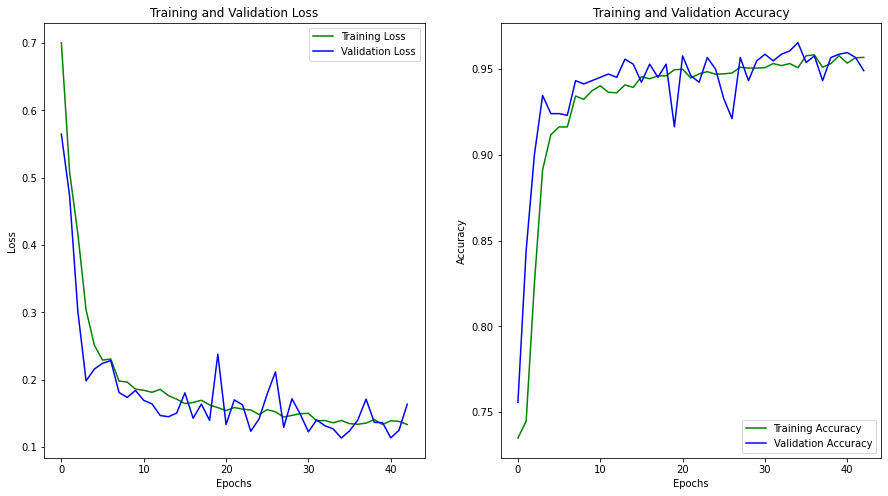

In [ ]:
model_graph(historyD)

As you can see above our model did improve a little, but now there are signs of underfitting. Remember how we mentioned above that there is imbalance in our dataset. Therefore in the following model we will be including the correction for imbalances to see if that fixes our issues.

## Convolutional Neural Networks - ModelI (Imbalance Correction)

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
VAL_IMG_COUNT = COUNT_NORMALV + COUNT_PNEUMONIAV

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 #Need to define train_img_count

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


In [ ]:
train_datagenI = ImageDataGenerator(rotation_range = 0.2,
                                   shear_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   fill_mode = 'nearest',
                                   rescale = 1./255)
test_datagenI = ImageDataGenerator(rescale = 1./255)
train_generatorI = train_datagenI.flow(x = x_train, y = y_train, batch_size = 16, seed = 123)
val_generatorI = test_datagenI.flow(x = x_val, y = y_val, batch_size = 16, seed = 123)
test_generatorI = test_datagenI.flow_from_directory(
        '/content/drive/My Drive/Flatiron School/chest_xray/test',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 624 images belonging to 2 classes.


In [ ]:
modelI = models.Sequential()
modelI.add(layers.Conv2D(32, (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
modelI.add(layers.MaxPooling2D((2, 2)))
modelI.add(layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.005)))
modelI.add(layers.MaxPooling2D((2, 2)))
modelI.add(layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.005)))
modelI.add(layers.MaxPooling2D((2, 2)))
modelI.add(layers.Flatten())
modelI.add(layers.Dropout(0.4))
modelI.add(layers.Dense(128, activation = 'relu'))
modelI.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
nadam = optimizers.Nadam(learning_rate = 1e-5)
modelI.compile(loss = 'binary_crossentropy',
              optimizer = 'nadam',
              metrics = ['acc'])

In [ ]:
historyI = modelI.fit(train_generatorI,
                    steps_per_epoch = 261,
                    epochs = 50,
                    validation_data = val_generatorI,
                    validation_steps = 65,
                    verbose = 0,
                    callbacks = [callback],
                    class_weight = class_weight)

In [ ]:
test_lossI, test_accI = modelI.evaluate_generator(test_generatorI, steps=39)
print('test acc:', test_accI)

test acc: 0.8717948794364929


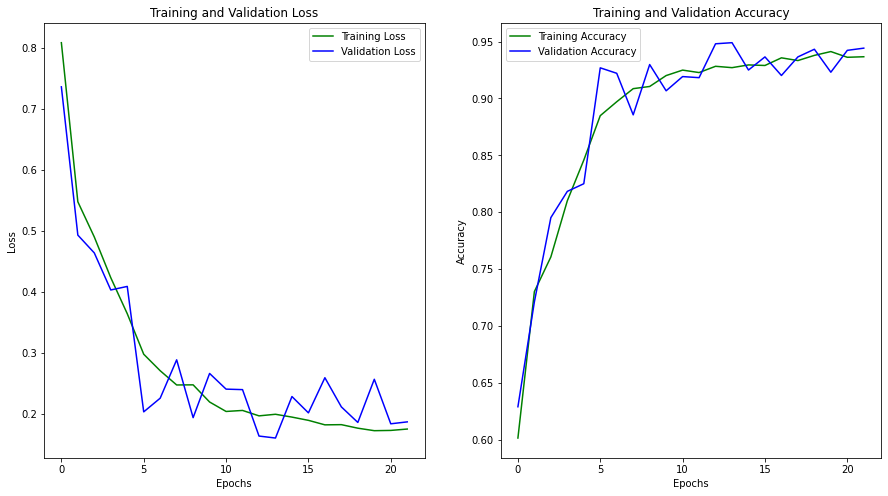

In [ ]:
model_graph(historyI)

This is our best model so far. There are things that we can do to fix the fluctuation here. But due to time constraint we shall leave it as is for now. We shall now look at the modeling recall, precision, accuracy, and auc scores below.

In [ ]:
modelnames = ['modelB', 'modelD', 'modelI']
recallval = [recall_score(test_generatorB.labels, predicted_valsB>0.5, average = 'weighted'), 
             recall_score(test_generatorD.labels, predicted_valsD>0.5, average = 'weighted'),
             recall_score(test_generatorI.labels, predicted_valsI>0.5, average = 'weighted')]
precisionval = [precision_score(test_generatorB.labels, predicted_valsB>0.5, average = 'weighted'),
                precision_score(test_generatorD.labels, predicted_valsD>0.5, average = 'weighted'),
                precision_score(test_generatorI.labels, predicted_valsI>0.5, average = 'weighted')]
f1scoreval = [f1_score(test_generatorB.labels, predicted_valsB>0.5, average = 'weighted'),
              f1_score(test_generatorD.labels, predicted_valsD>0.5, average = 'weighted'),
              f1_score(test_generatorI.labels, predicted_valsI>0.5, average = 'weighted')]
auccuracyval = [accuracy_score(test_generatorB.labels, predicted_valsB>0.5),
                accuracy_score(test_generatorD.labels, predicted_valsD>0.5),
                accuracy_score(test_generatorI.labels, predicted_valsI>0.5)] 
aucval = [roc_auc_score(test_generatorB.labels, predicted_valsB>0.5, average = 'weighted'),
          roc_auc_score(test_generatorD.labels, predicted_valsD>0.5, average = 'weighted'),
          roc_auc_score(test_generatorI.labels, predicted_valsI>0.5, average = 'weighted')]


In [ ]:
modelsummary = {
    'Model': modelnames,
    'Recall Score': recallval,
    'Precision Score': precisionval,
    'F1 Score': f1scoreval,
    'Testing Accuracy': auccuracyval,
    'AUC Score': aucval
}

In [ ]:
modelsummary = pd.DataFrame(modelsummary)
modelsummary

,Model,Recall Score,Precision Score,F1 Score,Testing Accuracy,AUC Score
0,modelB,0.599359,0.534569,0.524400,0.599359,0.501709
1,modelD,0.552885,0.526310,0.534024,0.552885,0.495299
2,modelI,0.570513,0.552769,0.558420,0.570513,0.521368


Based off of the table above, these are the results of our modeling.



*   Recall/Accuracy - ModelB
*   Precicion/F1 Score/ AUC - ModelI



# Visualizations

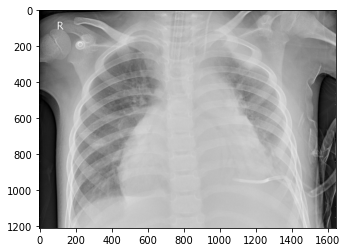

In [ ]:
img = image.load_img('/content/drive/My Drive/Flatiron School/chest_xray/train/PNEUMONIA/person1411_bacteria_3604.jpeg')
plt.imshow(img)
#Pneumonia

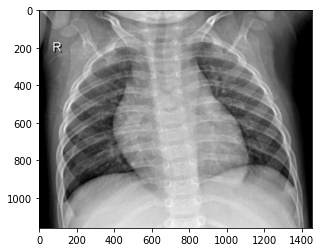

In [ ]:
img = image.load_img('/content/drive/My Drive/Flatiron School/chest_xray/train/NORMAL/IM-0706-0001.jpeg')
plt.imshow(img)
#Normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


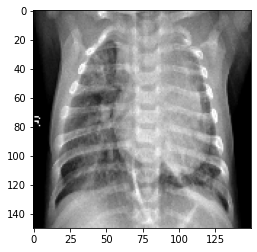

In [ ]:
img = image.load_img('/content/drive/My Drive/Flatiron School/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg', target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 225

plt.imshow(img_tensor[0])

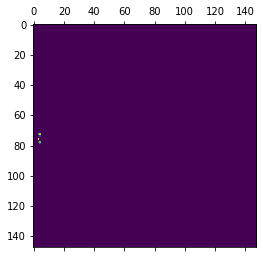

In [ ]:
#Fourth Channel
layer_outputs = [layer.output for layer in modelI.layers[:8]]
activation_model = models.Model(inputs = modelI.input, outputs = layer_outputs)

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap = 'viridis')

In [ ]:
print(first_layer_activation.shape)
#It's a 148 x 148 feature map with 32 channels.

(1, 148, 148, 32)


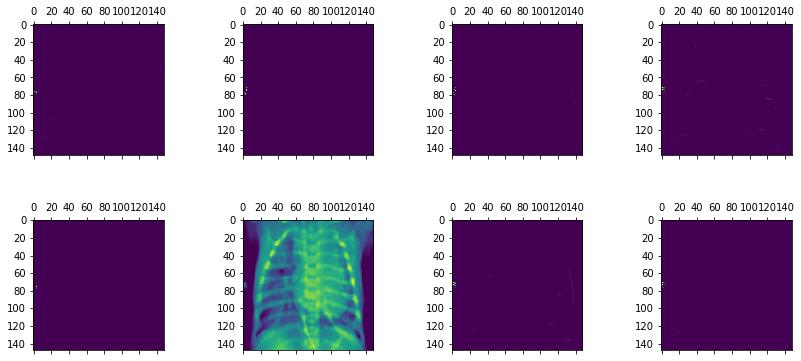

In [ ]:
# All channels of first layer activation
channels = [0, 1, 2, 3, 4, 5, 6, 7]
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for val in channels:
  axs[val].matshow(first_layer_activation[0, :, :, val], cmap = 'viridis')

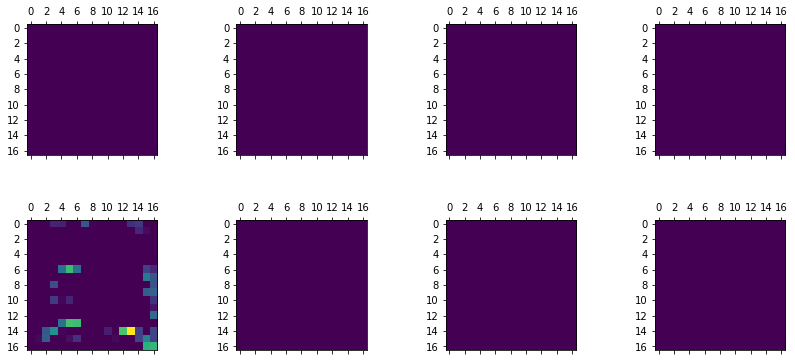

In [ ]:
# All channels of sixth layer activation
sixth_layer_activation = activations[5]
channels = [0, 1, 2, 3, 4, 5, 6, 7]
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for val in channels:
  axs[val].matshow(sixth_layer_activation[0, :, :, val], cmap = 'viridis')

After looking at the visualizations of the channels in our first activation layer and sixth activation layer, we noticed some stuff. In the channels of the first activation layer they looking for specific details, while in the sixth activation layer they are looking for broader details. Now let us look at the ROC AUC graph made by the three models above.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


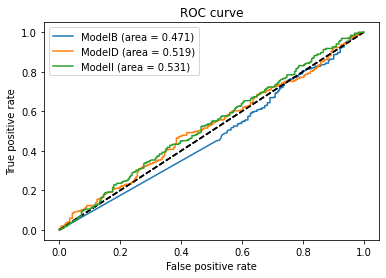

In [ ]:
y_predB = modelB.predict(test_generatorB).ravel()
fpr_kerasB, tpr_kerasB, thresholds_kerasB = roc_curve(test_generatorB.labels, y_predB)
auc_kerasB = auc(fpr_kerasB, tpr_kerasB)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_kerasB, tpr_kerasB, label='ModelB (area = {:.3f})'.format(auc_kerasB))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

y_predD = modelD.predict(test_generatorD).ravel()
fpr_kerasD, tpr_kerasD, thresholds_kerasD = roc_curve(test_generatorD.labels, y_predD)
auc_kerasD = auc(fpr_kerasD, tpr_kerasD)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_kerasD, tpr_kerasD, label='ModelD (area = {:.3f})'.format(auc_kerasD))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

y_predI = modelI.predict(test_generatorI).ravel()
fpr_kerasI, tpr_kerasI, thresholds_kerasI = roc_curve(test_generatorI.labels, y_predI)
auc_kerasI = auc(fpr_kerasI, tpr_kerasI)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_kerasI, tpr_kerasI, label='ModelI (area = {:.3f})'.format(auc_kerasI))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

As you can see here that the last model which included all the dropout, regularizations, lower learning rate and imbalance corrections did the best of the three models.

# Conclusion

To summarize everything above, we can see from above that 

* Recall/Accuracy - ModelB
* Precicion/F1 Score/ AUC - ModelI

Our goal is to minimize the amount of people we classify as being normal, but they indeed do have Pneumonia. Therefore we would want to minimize false negatives in other words maximizing recall. Our recommendation is to stick with ModelI. Although modelB was slightly better in recall and accuracy, there was only a slight difference in the recall and accuracy score. Also ModelI did better in precision score, F1 score and AUC score. Therefore ModelI is the best model to use for predictions.